##Setup

In [58]:
from matplotlib import rc
rc('animation', html='jshtml')

from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation


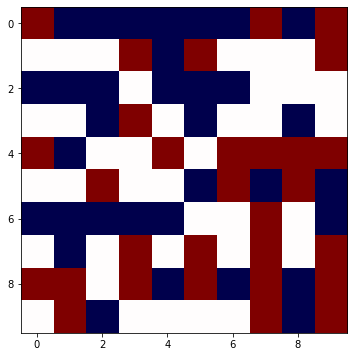

In [59]:
fig = plt.figure(figsize=(6,6))


test_map = [np.random.randint(-1,2, (10,10)) for i in range(10)]

def frame(w, args):
    ax = args
    ax.clear()
    
    plot_list = []
    for i in w:
      plot_list.append(ax.imshow(w, cmap = 'seismic'))
    return plot_list

#frames - list of map matrices [-1] enemy, [0] neurtal, [1] friendly
def anim_builder(frames):
  ax = fig.add_subplot(111)
  anim = animation.FuncAnimation(fig, frame, frames=frames, fargs = [ax], blit=True, repeat=True)
  return anim

anim_builder(test_map)

In [83]:
#call for getting adjacent cell features
def get_cell_feats(state_mat, y,x, n = 1):

    if x >= state_mat.shape[1] or x < 0:
      print('ERROR INVALID X CORD')

    if y >= state_mat.shape[0] or y < 0:
      print('ERROR INVALID Y CORD')

    adj_vals = state_mat.take(range(y-n,y+n+1),mode='wrap', axis=0).take(range(x-n,x+n+1),mode='wrap',axis=1)
    return adj_vals

##first_enemy_agent, attacks first enemy in view<br>
##Rand_enemy_agent, attacks random enemy in view

In [61]:
def simple_adj(feat_mat): #helper function from individual cell perspective
    
    feat_mat = feat_mat.reshape(-1,1)

    enemy_list = np.argwhere(feat_mat == -1)[:,0]
    empty_list = np.argwhere(feat_mat == 0)[:,0]

    if len(enemy_list)>=1:
      return enemy_list[0]
    elif len(empty_list)>=1:
      return empty_list[1]
    else:
      return int(len(feat_mat)/2)

def rand_adj(feat_mat): #helper function from individual cell perspective
    
    feat_mat = feat_mat.reshape(-1,1)

    enemy_list = np.argwhere(feat_mat == -1)[:,0]
    empty_list = np.argwhere(feat_mat == 0)[:,0]

    if len(enemy_list)>=1:
      #print(enemy_list)
      return np.random.choice(enemy_list,1)[0]
    elif len(empty_list)>=1:
      return np.random.choice(empty_list,1)[0]
    else:
      return int(len(feat_mat)/2)


def first_enemy_agent(state_mat):
  attack_mat =np.zeros(state_mat.shape)


  for i in range(attack_mat.shape[0]):
    for j in range(attack_mat.shape[1]):
      attack_mat[i,j] = simple_adj(get_cell_feats(state_mat, i,j)) #get cell feats returns adjacent cells

  return attack_mat.astype(int)
  

def rand_enemy_agent(state_mat):
  attack_mat =np.zeros(state_mat.shape)

  for i in range(attack_mat.shape[0]):
    for j in range(attack_mat.shape[1]):
      attack_mat[i,j] = rand_adj(get_cell_feats(state_mat, i,j)) #get cell feats returns adjacent cells

  return attack_mat.astype(int)

In [62]:
rand_enemy_agent(np.random.randint(-1,2,(10,10)).astype(int))

array([[5, 2, 5, 2, 5, 7, 4, 1, 7, 8],
       [6, 3, 4, 3, 4, 6, 3, 8, 5, 2],
       [1, 0, 3, 0, 3, 3, 5, 8, 2, 1],
       [4, 1, 5, 2, 5, 2, 4, 7, 4, 0],
       [5, 2, 2, 7, 8, 3, 0, 8, 3, 6],
       [7, 4, 2, 0, 3, 7, 7, 7, 1, 1],
       [8, 2, 8, 1, 2, 6, 0, 3, 0, 0],
       [8, 3, 0, 0, 7, 5, 1, 7, 6, 7],
       [7, 0, 6, 3, 7, 4, 1, 2, 5, 6],
       [6, 3, 8, 5, 2, 8, 5, 2, 4, 4]])

##cgol (competitive game of life)

In [63]:
view_cords = np.where(np.zeros((3, 3))==0)

x_view = view_cords[1] - int(np.floor(3/2))
y_view = view_cords[0] - int(np.floor(3/2))

print(y_view)
print(x_view)

[-1 -1 -1  0  0  0  1  1  1]
[-1  0  1 -1  0  1 -1  0  1]


In [64]:
from scipy import signal


#10*10 grid
#-1 is agent 1
#0 is None
#1 is agent 2

class cgol:
  def  __init__(self, agent_1, agent_2, board_h = 10, board_w = 10):

    self.board_h = board_h
    self.board_w = board_w
    self.view_width = 3
    self.view_height = 3

    self.state_mat = np.zeros((self.board_h,self.board_w))

    self.agent_1 = agent_1
    self.agent_2 = agent_2

    num_starting = int(np.random.randint(3,4))#start with a random number of seeds from 0-10

    #set starting locations for adjent
    game_x = np.random.randint(0,board_h, num_starting) #starting locations for agent_1_x
    game_y = np.random.randint(0,board_w, num_starting) #starting locations for agent_1_y
    self.state_mat[game_x,game_y] = -1

    game_x = np.random.randint(0,board_h, num_starting) #starting locations for agent_1_x
    game_y = np.random.randint(0,board_w, num_starting) #starting locations for agent_1_y
    self.state_mat[game_x,game_y] = 1
    
    #mapping for action int to 
    view_cords = np.where(np.zeros((self.view_width, self.view_height))==0)

    self.x_view = view_cords[1] - int(np.floor(self.view_width/2))
    self.y_view = view_cords[0] - int(np.floor(self.view_height/2))

    #recording history
    self.state_history = []
    self.p1_history = []
    self.p2_history = []
    self.reward = []
    self.count = 0

  def get_state(self):
    return self.state_mat

  #translates individual cell action from int to cordinate
  def translate_action(self, x_cord, y_cord, action_int):
    action_x = self.x_view[action_int]
    action_y = self.y_view[action_int]

    x_add = (x_cord + action_x)%self.board_w
    y_add = (y_cord + action_y)%self.board_h

    return np.array([y_add,x_add])

  #moves from cords to attack to attack_map
  #action_map - map of board with actions assigned integer based on coord
  #ex:
  # [1 3 4 5 0 9]      [sum of adjent attacks]
  # [3 4 9 8 6 2]      [                     ]
  # [1 0 6 7 5 3] ---> [                     ]
  # [0 0 0 4 5 6]      [                     ]
  def convert_action_map(self, action_map, self_cords):
    y_cord = self_cords[0]
    x_cord = self_cords[1]

    if len(y_cord) > 0:
      action_list = [action_map[y_cord[i], x_cord[i]] for i in range(len(x_cord))]
      action_cords = np.stack([self.translate_action(x_cord[i], y_cord[i], action_list[i]) for i in range(len(action_list))])

    else: #case where there are no more agents on the field
      return np.zeros((self.board_h, self.board_w))

    action_count = np.zeros((self.board_h, self.board_w))
    action_count[action_cords[:,0], action_cords[:,1]]+=1
    return action_count

  #action mat - the action being played for this step by agent_1
  #agent 2 - the second agent strategy
  #returns - reward, done
  def step(self, action_mat, agent_2):
    
    p1_view = self.state_mat
    p2_view = self.state_mat * -1

    #print(p1_view)

    #retrieve adjent actions
    p1_action = action_mat #here agent 1's action replaced by input action
    p2_action = self.agent_2(p2_view)

    ##retrieve adjent coordinates
    p1_cords = np.where(p1_view==1)
    p2_cords = np.where(p2_view==1)


    #translate adjent actions into sum attack matrices
    p1_action = self.convert_action_map(p1_action, p1_cords)
    p2_action = self.convert_action_map(p2_action, p2_cords)

    #update game state
    self.state_mat+=p1_action
    self.state_mat-=p2_action

    self.state_mat[self.state_mat<-1]=-1
    self.state_mat[self.state_mat>=1]=1

    ###ADD PUNISHMENT FOR OVERPOPULATION #################################
    abs_map = np.abs(self.state_mat)
    sum_mat = signal.convolve2d(abs_map, np.ones((3,3)), boundary = 'wrap', mode = 'same')
    excess_mat = 1-(sum_mat>6)
    self.state_mat = self.state_mat * excess_mat
    ###ADD PUNISHMENT FOR OVERPOPULATION #################################

    self.state_history.append(self.state_mat.copy())
    self.p1_history.append(p1_action)
    self.p2_history.append(p2_action)

    reward = signal.convolve2d(self.state_mat, np.ones((3,3)), boundary = 'wrap', mode = 'same')
    
    done = False

    if np.min(self.state_mat) == 1:
      done = True
      #reward = 10000
    if np.max(self.state_mat) == -1:
      done = True
      #reward = -100
    if self.count >= 100:
      done = True

    self.count+=1

    return reward, done


  #step the simulation on timestep
  def sim_step(self, agent_1 = None, agent_2 = None):
    p1_view = self.state_mat
    p2_view = self.state_mat * -1

    #print(p1_view)

    #retrieve adjent actions
    p1_action = self.agent_1(p1_view)
    p2_action = self.agent_2(p2_view)

    ##retrieve adjent coordinates
    p1_cords = np.where(p1_view==1)
    p2_cords = np.where(p2_view==1)


    #translate adjent actions into sum attack matrices
    p1_action = self.convert_action_map(p1_action, p1_cords)
    p2_action = self.convert_action_map(p2_action, p2_cords)

    #update game state
    self.state_mat+=p1_action
    self.state_mat-=p2_action

    self.state_mat[self.state_mat<-1]=-1
    self.state_mat[self.state_mat>=1]=1

    ###ADD PUNISHMENT FOR OVERPOPULATION #################################
    abs_map = np.abs(self.state_mat)
    sum_mat = signal.convolve2d(abs_map, np.ones((3,3)), boundary = 'wrap', mode = 'same')
    excess_mat = 1-(sum_mat>5)
    self.state_mat = self.state_mat * excess_mat
    ###ADD PUNISHMENT FOR OVERPOPULATION #################################

    self.state_history.append(self.state_mat.copy())
    self.p1_history.append(p1_action)
    self.p2_history.append(p2_action)

    #print(self.state_mat)
    return self.state_mat.copy()


  #returns a history of the game
  def run_game(self, n_steps = 10):
    state_mats = [self.sim_step() for i in range(n_steps)]

    return state_mats
  


##Random Agent, attacks randomly

In [65]:
def rand_agent(state_mat):
  return np.random.randint(0,3, state_mat.shape).astype(int)



In [66]:
rand_agent(np.random.randint(-1,2,(10,10)).astype(int))

array([[2, 2, 1, 0, 2, 1, 2, 1, 2, 0],
       [0, 0, 2, 0, 1, 1, 0, 1, 0, 1],
       [0, 2, 0, 0, 0, 1, 0, 0, 1, 0],
       [1, 1, 0, 2, 2, 1, 1, 2, 1, 2],
       [0, 2, 0, 0, 0, 1, 2, 0, 2, 2],
       [1, 0, 1, 0, 2, 2, 1, 0, 2, 1],
       [1, 2, 0, 1, 2, 0, 2, 2, 2, 1],
       [2, 0, 2, 2, 1, 0, 1, 1, 1, 0],
       [1, 2, 0, 2, 1, 1, 1, 2, 1, 1],
       [0, 1, 2, 2, 2, 0, 0, 0, 0, 2]])

##Test of the game

In [67]:
test_game = cgol(rand_enemy_agent, rand_enemy_agent)

game_hist = test_game.run_game(100)

anim_builder(game_hist)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


##Tests of named tuple

In [68]:
from collections import namedtuple, deque

In [69]:
Point = namedtuple("Point", ("x","y"))

point = Point(2,4)

point

Point(x=2, y=4)

# Deep Q learning

###imports for deep Q

In [70]:
#import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T



# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###settings for the game 


In [71]:
game_w = 20
game_h = 20

attack_w = 3
attack_h = 3

###Settings for DQN

In [84]:
num_episodes = 1000
BATCH_SIZE = 100
GAMMA = 0.8
EPS_START = 0.8
EPS_END = 0.05
EPS_DECAY = 600
TARGET_UPDATE = 10

##Replay Memory


In [73]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity) #creates queue accessable from both ends

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args)) #appends one ('state','action','next_state','reward') to the dequeue

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size) #randomly samples from the dequeue

    def __len__(self):
        return len(self.memory) #number of elements in the dequeue

##Q-network

In [74]:
class DQN(nn.Module):

    def __init__(self, h, w):
        super(DQN, self).__init__()
        #this convolution takes input of 1 channel, outputs 16 channels
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1,padding="same" , padding_mode = 'circular') #switched to match 1-channel image, circular stride (There are no walls)
        self.bn1 = nn.BatchNorm2d(16)
        #self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1,padding="same" , padding_mode = 'circular')
        #self.bn2 = nn.BatchNorm2d(16)
        #self.conv3 = nn.Conv2d(16, 16, kernel_size=3, stride=1,padding="same" , padding_mode = 'circular')
        #self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 9, kernel_size=3, stride=1,padding="same" , padding_mode = 'circular')
        self.bn4 = nn.BatchNorm2d(9)

        #end with 9 outputs as thats the size of the choices to attack (3*3)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        #x = F.relu(self.bn2(self.conv2(x)))
        #x = F.relu(self.bn3(self.conv3(x)))
        return F.relu(self.bn4(self.conv4(x)))

## Training

### Hyperparameters and utilities
This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the durations of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.

In [86]:
# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
screen_height = game_h
screen_width = game_w

# Get number of actions from gym action space
n_actions = game_h*game_w #NEED AN ACTION FOR EACH POTENTIAL 

policy_net = DQN(screen_height, screen_width).to(device)
target_net = DQN(screen_height, screen_width).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(1000)


steps_done = 0

###Select Action

In [87]:
#State should take input as [N,C,H,W]
steps_done=0

def select_action(state):
    global steps_done

    #calculate the likelihood of a random move
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)

    steps_done+=1

    rand_action_mat = np.random.randint(0,9, (1,1,game_h,game_w))
    rand_action_mat = torch.from_numpy(rand_action_mat.astype(int)).to(device)

    rand_mask = np.random.binomial(1,1-eps_threshold, (1,1,game_h, game_w))
    rand_mask = torch.from_numpy(rand_mask.astype(int)).to(device)

    with torch.no_grad():
        # if working correctly this should return a hight*width matrix of attack picks
        res = policy_net(state)
        #print(res.size())
        res = res.max(1)[1] #max of dimension 1 gets the max along the attack moves, [1] gets the indices instead of the tensors themselves
        res = res.reshape(1,1,game_h, game_w)

        return res
    #returns (batch, Height, Width)

### Optimize Model

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By definition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network has its weights kept frozen most of
the time, but is updated with the policy network's weights every so often.
This is usually a set number of steps but we shall use episodes for
simplicity.

In [88]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions)) #I believe?? this creates a transition with a list for each element (current state, current action, ...)

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)# boolean array of valid next states
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None]) #array of all next states that are valid
    
    state_batch = torch.cat(batch.state) #array of all states
    action_batch = torch.cat(batch.action) #array of all actions
    reward_batch = torch.cat(batch.reward) #array of all rewards

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net

    state_action_values = policy_net(state_batch).gather(1, action_batch) #gather lets one select the index of state_batch via action_batch

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros((BATCH_SIZE, game_h, game_w), device=device)
    #print(next_state_values.shape)

    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    #expected_state_action_values = (next_state_values * GAMMA) + reward_batch.reshape(-1,1,1).repeat(1,game_w,game_h)
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch.reshape(-1, game_h, game_w)

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Below, you can find the main training loop. At the beginning we reset
the environment and initialize the ``state`` Tensor. Then, we sample
an action, execute it, observe the next screen and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set small. You should download
the notebook and run lot more epsiodes, such as 300+ for meaningful
duration improvements.

In [89]:
def DQN_policy_agent(state_mat):
  state = state_mat.copy()
  state = state.reshape(1,1,game_h, game_w).astype(np.float32)
  state = torch.from_numpy(state)
  
  game_action = policy_net(state)
  #print(res.size())
  game_action = game_action.max(1)[1] #max of dimension 1 gets the max along the attack moves, [1] gets the indices instead of the tensors themselves
  game_action = game_action.cpu().numpy()
  game_action = game_action[0,:, :]


  return game_action

###training loop

### DQN policy agent

In [90]:

#num_episodes = 1000
for i_episode in range(num_episodes):
    # Initialize the environment and state
    #env.reset()
    test_game = cgol(rand_enemy_agent, rand_enemy_agent, game_h, game_w)
    state = test_game.get_state()
    state = state.reshape(1,1,game_h, game_w).astype(np.float32)
    state = torch.from_numpy(state)
    
    for t in range(100):
        # Select and perform an action based on state (action is shape (1,1,H,W))
        action = select_action(state)

        game_action = action.cpu().numpy()
        game_action = game_action[0,0,:,:] #get only the H-W slice

        reward, done = test_game.step(game_action, rand_enemy_agent)

        reward = reward.reshape(1,1,game_h,game_w)
        reward = torch.tensor(reward, device=device)
        #print(reward.shape)

        # Observe new state
        if not done:
            next_state = test_game.get_state()
            next_state = next_state.reshape(1,1,game_h, game_w).astype(np.float32)
            next_state = torch.from_numpy(next_state)
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        if done:
            break

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    print('episode: ' + str(i_episode) + ' duration: ' + str(t) + ' reward: ' + str(torch.sum(reward)))
print('Complete')

episode: 0 duration: 99 reward: tensor(-1107., device='cuda:0', dtype=torch.float64)
episode: 1 duration: 99 reward: tensor(-477., device='cuda:0', dtype=torch.float64)
episode: 2 duration: 99 reward: tensor(-1242., device='cuda:0', dtype=torch.float64)
episode: 3 duration: 99 reward: tensor(-1098., device='cuda:0', dtype=torch.float64)
episode: 4 duration: 99 reward: tensor(-1071., device='cuda:0', dtype=torch.float64)
episode: 5 duration: 99 reward: tensor(-1314., device='cuda:0', dtype=torch.float64)
episode: 6 duration: 99 reward: tensor(-1188., device='cuda:0', dtype=torch.float64)
episode: 7 duration: 99 reward: tensor(-1062., device='cuda:0', dtype=torch.float64)
episode: 8 duration: 99 reward: tensor(-1251., device='cuda:0', dtype=torch.float64)
episode: 9 duration: 99 reward: tensor(-621., device='cuda:0', dtype=torch.float64)
episode: 10 duration: 99 reward: tensor(-540., device='cuda:0', dtype=torch.float64)
episode: 11 duration: 99 reward: tensor(-297., device='cuda:0', dty

KeyboardInterrupt: ignored

##Test a DQN-trained agent

In [91]:
#test the game
test_game = cgol(DQN_policy_agent,rand_enemy_agent, game_h, game_w)

game_hist = test_game.run_game(100)

anim_builder(game_hist)
#anim = anim_builder(game_hist)
#anim.save('DQN_v_rand_20_20.gif', writer='pillow', fps=60)
#anim

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [92]:
test_game = cgol(DQN_policy_agent, DQN_policy_agent, game_h, game_w)

game_hist = test_game.run_game(150)
#anim_builder(game_hist)

anim = anim_builder(game_hist)
#anim.save('DQN_v_DQN_20_20.gif', writer='pillow', fps=30)
anim

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [ ]:
test_game = cgol(DQN_policy_agent,DQN_policy_agent, game_5, game_w)

game_hist = test_game.run_game(100)

anim_builder(game_hist)